**Importing Libraries**

In [6]:
import tensorflow as tf
from tensorflow.keras import models,layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import numpy as np
from skimage import data, io, img_as_ubyte, measure
from skimage.filters import threshold_multiotsu, threshold_otsu
from skimage.color import rgb2gray, label2rgb
import cv2

from scipy import ndimage as nd 

ModuleNotFoundError: No module named 'skimage'

**Setting constants**

In [2]:
IMG_SIZE = 1024
BATCH_SIZE = 10
CHANNELS = 3
EPOCHS = 100

**Loading data into tensorflow dataset object**

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE
)

# Getting the class names
class_names = dataset.class_names
class_names

Found 208 files belonging to 4 classes.


['-K', '-N', '-P', 'FN']

**Visualizing some of the images**

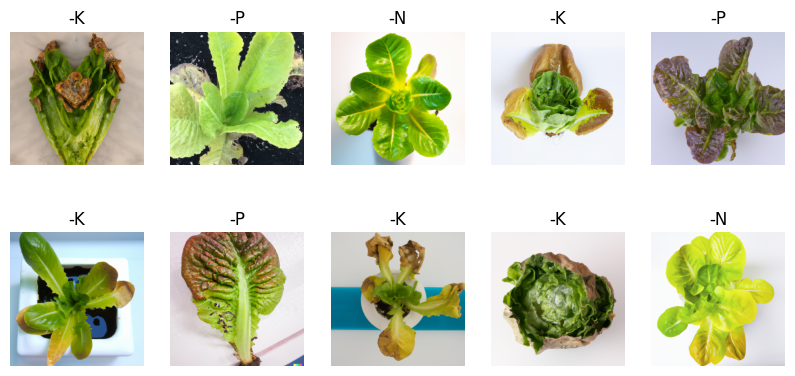

In [11]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

**Constants for data splitting**

In [14]:
dataset_size = len(dataset)       # 21 (number of pictures/batch_size)
train_size = 0.8                  # training = 10%
val_size = 0.1                    # validation = 10%
test_size = 0.1                   # test = 10%

**Function for data splitting**

In [15]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
  
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_data = ds.take(train_size)    
    val_data = ds.skip(train_size).take(val_size)
    test_data = ds.skip(train_size).skip(val_size)

    return train_data, val_data, test_data

**Data Splitting**

In [16]:
train_data, val_data, test_data = split_dataset(dataset)
len(train_data), len(val_data), len(test_data)

(16, 2, 3)

**Cache, Shuffle, and Prefetch**\
Cache - cache the dataset in memory\
Shuffle - shuffle the images\
Prefetch - overlaps the preprocessing and model execution of a training step\
This is to reduce memory usage and optimize the pipeline performance.
https://www.tensorflow.org/guide/data_performance

In [17]:
train_data = train_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

**Image Segmentation with Automatic Thresholding using Multi-Otsu (Grayscale)** \
Automatic Thresholding using Multi-Otsu was implemented to Keras as a custom layer using subclassing. Please visit [Tensorflow - Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) for more information. 

The [Otsu method](https://muthu.co/otsus-method-for-image-thresholding-explained-and-implemented/) utilizes the variance in the histogram to find the threshold used to segment the image. 

In [ ]:
class MultiOtsuGray(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(MultiOtsuGray, self).__init__(**kwargs)

  def call(self, image):

    # Convert image to grayscale
    np_image = image.numpy()
    gray = rgb2gray(np_image)

    # Find thresohld and get mask based on threshold
    ts = threshold_multiotsu(gray)
    binary_mask_1 = gray > ts[0] 
    binary_mask_2 = gray < ts[-1]  

    # Apply mask and convert from Numpy to Tensor
    np_image[~binary_mask_1] = 0
    np_image[~binary_mask_2] = 0
    tf_image = tf.convert_to_tensor(np_image) 

    return tf_image      

MultiOtsuGray = tf.keras.Sequential([
  #layers.RandomCrop(1000,1000)
  MultiOtsuGray()
])

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(10):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(MultiOtsuGray(image_batch[i]).numpy().astype('uint8'), cmap="gray")
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

**Image Segmentation with HSV Segmentation** 

Automatic Thresholding using Multi-Otsu was implemented to Keras as a custom layer using subclassing. Please visit [Tensorflow - Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) for more information.

In [ ]:
class HSVSegmentation(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(HSVSegmentation, self).__init__(**kwargs)

  def call(self, image):
   
    # Convert from RGB to HSV
    image = image.numpy()
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Get mask based on color range
    mask = cv2.inRange(img_hsv, (30, 0, 0), (86,255,255))
    mask_black = cv2.inRange(img_hsv, (0,0,0), (180,255,40))
    mask_total = mask + mask_black
    closed_mask = nd.binary_closing(mask, np.ones((15,15)))
    label_image = measure.label(closed_mask)
    image_label_overlay = label2rgb(label_image, image = image)
    segmented = cv2.bitwise_and(image, image, mask=mask_total)


    # Convert Numpy to Tensor
    tf_image = tf.convert_to_tensor(segmented) 

    return tf_image      

HSVSegmentation = tf.keras.Sequential([
  #layers.RandomCrop(1000,1000)
  HSVSegmentation()
])

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(10):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(MultiOtsuHSV(image_batch[i]).numpy().astype('uint8'), cmap="gray")
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

**Resizing and Normalization** \
Since majority of the images in the dataset are in the size 1024x1024, in this layer the images will be resized to the desired size 1024x1024. The image pixel value will be normalized or rescaled to a range from 0 to 1. This is to improve model performance.\
https://stackoverflow.com/questions/66971140/what-rescaling-actually-does-in-tensorflow \
https://www.tensorflow.org/guide/data_performance

In [23]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1.0/255),
]) #layers.experimental.preprocessing.Resizing

**Data Augmentation**

In [30]:
data_augmentation = tf.keras.Sequential([
    #layers.RandomCrop(1000,1000)
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant', fill_value=0.0),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
])